## VM setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/Master Thesis/Language Model Training"

/content/gdrive/MyDrive/Master Thesis/Language Model Training


In [ ]:
!pip install transformers==4.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 29.7 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 880 kB 57.6 MB/s 
     |████████████████████████████████| 6.6 MB 28.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a229ecd986149429b11c9c98fba274b8863d8106e1a914ef49ee3ed36a10b005
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 32.4 MB/s 
     |████████████████████████████████| 115 kB 71.4 MB/s 
     |████████████████████████████████| 141 kB 63.9 MB/s 
     |████████████████████████████████| 212 kB 57.7 MB/s 
     |████████████████████████████████| 127 kB 68.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
from torch import cuda
import transformers
from transformers import RobertaModel
from transformers import RobertaTokenizerFast
from transformers import TrainerCallback
import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from collections import ChainMap
import random
from tqdm import tqdm
import shutil
from datetime import datetime
import json
import os

In [ ]:
import multiprocessing

core_count = multiprocessing.cpu_count() # Count the number of cores in a computer
core_count

2

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Helper functions

In [ ]:
def moving_avg(mylist, N=5):
    try:
        shape = mylist.shape
        mylist = np.ravel(mylist)
    except AttributeError:
        shape = (1, -1)

    cumsum, moving_aves = [0], []

    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    diff = len(mylist) - len(moving_aves)
    if diff > 0:
        tmp = [0 for i in range(diff)]
        tmp.extend(moving_aves)
        moving_aves = tmp

    return np.asarray(moving_aves).reshape(shape)


## Load Tokenizer



In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("./TwitchLeagueBert")

## Load data

In [ ]:
ds_chk_seq_targets_padded_simple = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced_targets_simple")

In [ ]:
ds_chk_seq_targets_padded_simple

DatasetDict({
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
        num_rows: 104252
    })
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
        num_rows: 33160
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
        num_rows: 34045
    })
})

In [ ]:
small_ds = datasets.Dataset.from_dict(ds_chk_seq_targets_padded_simple["val"][12300:15000])

In [ ]:
small_ds

Dataset({
    features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
    num_rows: 2700
})

In [ ]:
flat_highlights = np.ravel(small_ds["hl_labels"])

In [ ]:
"number of highlight chunks", sum(flat_highlights)

('number of highlight chunks', 828.0)

In [ ]:
"total number of chunks", len(flat_highlights)

('total number of chunks', 5400)

In [ ]:
"ratio non-highlight / highlight", sum(flat_highlights)/len(flat_highlights)

('ratio non-highlight / highlight', 0.15333333333333332)

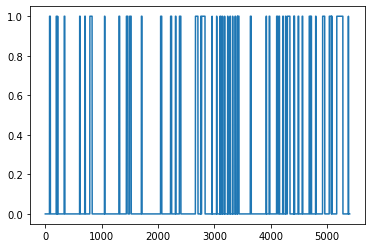

In [ ]:
plt.plot(list(range(len(flat_highlights))), flat_highlights)

## Load PlusTemporal model

In [ ]:
class LanguageModelPlusTemporal(torch.nn.Module):
  """
  TODO
  make a ModelConfig argument and Class to set the parameters for the model

  """
  def __init__(self, lm_path, additional_features_size, window_size, sequence_length, num_dist_categories, num_dist_steps, main_loss_ratio=1, pos_label_ratio=7.35):
        super(LanguageModelPlusTemporal, self).__init__()

        self.additional_features_size = additional_features_size # just random value for now
        self.window_size = window_size
        self.loss1_ratio = main_loss_ratio
        self.loss2_ratio = 1 - main_loss_ratio
        self.pos_label_ratio = torch.Tensor([pos_label_ratio]).to(device)
        self.l1 = RobertaModel.from_pretrained(lm_path)
        self.d1 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(128 + self.additional_features_size, 1024) # should be model_output_size (sequence length) + additional_features_size
        # maybe I should translate the additional features to a bigger
        # vectorspace so that they do not get drowned out by the sequence representation
        self.l41 = torch.nn.Linear(1024, window_size)
        # for each chunk in a sequence we have num_distcategories and each category has num_dist_steps number of discrete labels
        self.l42 = torch.nn.Linear(1024, sequence_length) # might have to add more here for each class and possible value
        # l42: maybe combine in-highlight output and outside-highlight output
    
  def forward(self, input_ids, attention_mask, additional_features, hl_labels=None, objective_simple=None, **kwargs):
        output_1 = self.l1(input_ids, attention_mask = attention_mask) # last_hidden_state, pooler_output
        # average lm last hidden layer outputs
        # alterntively use pooled output
        output_1_average = torch.mean(output_1.last_hidden_state, axis=-1)
        # concatenate sequence representation with additional temporal features
        input_2 = torch.concat([output_1_average, additional_features], axis=-1)
        # dropout
        output_2 = self.d1(input_2)
        # linear
        output_3 = self.l3(output_2)
        # for binary classification of main objective
        # define to return
        output = self.l41(output_3)
        # for multiclass classification of additional objective
        #output_42 = self.l42(output_3)
        #outputs = [output_41, output_42]

        # print("hl_labels", hl_labels is not None)
        # print("objective_simple", objective_simple is not None)
        # for compatibility with the huggingface Trainer API
        if hl_labels is not None:
          loss = self._get_loss(output, hl_labels)
          # TODO add normalization before returning outputs
          return {"loss": loss,
                  "logits": torch.sigmoid(output)}

        return {"logits": torch.sigmoid(output)}

  def _get_loss(self, outputs, targets):
    """
    for o, t in zip(outputs[0], targets[0]):
      loss += torch.nn.BCEWithLogitsLoss()(o, t)
    """
    # does this actually do what I want?
    # compute losses for n (window_size) outputs?
    # we can add weighing for the much smaller positive class with pos_weight
    loss1 = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_label_ratio)(torch.reshape(outputs, (outputs.shape[0]*self.window_size, 1)), torch.reshape(targets, (targets.shape[0]*self.window_size, 1))) # keep as is
    # print(outputs[1].size())
    # print(targets[1].size())
    # loss2 = torch.nn.CrossEntropyLoss()(outputs[1], targets[1]) # split into multiple softmaxes and losses
    

    # weighting of losses (schould be fine-tuned as well)
    # for example
    # loss1 * 0.9
    # loss2 * 0.1
    # log both losses => make sure both go down
    # losses = [loss1 * self.loss1_ratio, loss2 * self.loss2_ratio]
    return loss1

In [ ]:
model = LanguageModelPlusTemporal("./TwitchLeagueBert/", window_size=2, additional_features_size=4, sequence_length=4, num_dist_categories=4, num_dist_steps=6, main_loss_ratio=0.7, pos_label_ratio=7.35)
model.load_state_dict(torch.load("./LMPlusTemporal/checkpoint-4500/pytorch_model.bin", map_location=torch.device(device)))

Some weights of the model checkpoint at ./TwitchLeagueBert/ were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./TwitchLeagueBert/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
model.to(device)

LanguageModelPlusTemporal(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Prediction

In [ ]:
input_ids = [(iid + [tokenizer.pad_token_id] * 128)[:128] for iid in  small_ds['input_ids']]
attention_mask = [(atm + [0] * 128)[:128] for atm in small_ds['attention_mask']]
additional_features = small_ds["additional_features"]

In [ ]:
batch_size = 8

input_ids_batched = torch.IntTensor([input_ids[i:j] for i, j in zip(range(0,len(input_ids)-batch_size, batch_size), range(batch_size,len(input_ids), batch_size))]).to(device)
attention_mask_batched = torch.IntTensor([attention_mask[i:j] for i, j in zip(range(0,len(attention_mask)-batch_size, batch_size), range(batch_size,len(attention_mask), batch_size))]).to(device)
additional_features_batched = torch.Tensor([additional_features[i:j] for i, j in zip(range(0,len(additional_features)-batch_size, batch_size), range(batch_size,len(additional_features), batch_size))]).to(device)

In [ ]:
preds = list()
model.eval()

with torch.no_grad():
  for i in tqdm(range(len(input_ids_batched))):
    iids, atm, adf = input_ids_batched[i], attention_mask_batched[i], additional_features_batched[i]
    preds.append(model.forward(iids, atm, adf))

100%|██████████| 337/337 [00:09<00:00, 34.56it/s]


## Ouput inspection

In [ ]:
res = list()
# flatten output
for p in preds:
  res.extend(torch.flatten(p["logits"]).tolist())

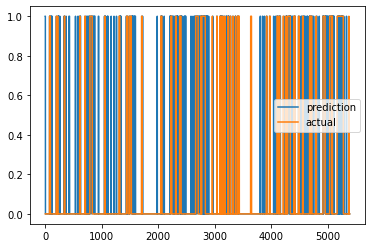

In [ ]:
plt_range = (0, len(res))
plt.plot(list(range(plt_range[1]-plt_range[0])), np.round(res[plt_range[0]: plt_range[1]]), label="prediction")
plt.plot(list(range(plt_range[1]-plt_range[0])), flat_highlights[plt_range[0]: plt_range[1]], label="actual")
plt.legend()
plt.show()

In [ ]:
msg_dens_flat = np.ravel(small_ds["additional_features"])

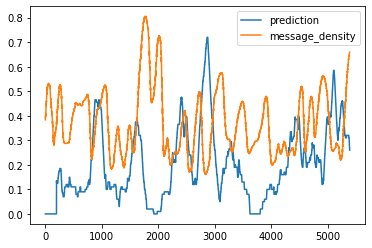

In [ ]:
plt.plot(list(range(plt_range[1]-plt_range[0])), moving_avg(np.round(res[plt_range[0]: plt_range[1]]), N=200), label="prediction")
plt.plot(list(range(plt_range[1]-plt_range[0])), msg_dens_flat[plt_range[0]: plt_range[1]], label="message_density")
plt.legend()
plt.show()

In [ ]:
original_text = tokenizer.batch_decode(input_ids)

In [ ]:
original_text[plt_range[0]: plt_range[1]]

['<s>Jebaited FLACID</s><s>🤔 Can 🤔 The 🤔 Mods 🤔 Ban 🤔 Us 🤔 All 🤔</s><s>ANELE</s><s>🤔 Was 🤔 9/11 🤔 An 🤔 inside 🤔 job? 🤔</s><s>111111 TSM 222222 C9</s><s>NA chat FailFish</s><s>🤔 Can 🤔 The 🤔 Mods 🤔 Ban 🤔 Us 🤔 All 🤔 1</s><s>SAME 2 ADC EVERY GAME</s><s>ResidentSleeper</s><s>ryze movespeed is stupid as hell LUL</s><s>lirikThump lirikThump lirikThump</s><s>ANELE IT IS TIME ANELE</s><s>PACKERS PogChamp</s><s>ANELE</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s>🤔 Can 🤔 The 🤔 Mods 🤔 Ban 🤔 Us 🤔 All 🤔 1</s><s>SAME 2 ADC EVERY GAME</s><s>ResidentSleeper</s><s>ryze movespeed is stupid as hell LUL</s><s>lirikThump lirikThump lirikThump</s><s>ANELE IT IS TIME ANELE</s><s>PACKERS PogChamp</s><s>ANELE</s><s>here we go again LUL</s><s>Kappa Kappa Kappa</s><s>🤔 CAN 🤔 THE 🤔 MODS 🤔 BAN 🤔 US 🤔 ALL 🤔</s><s>ANELE</s><s>Kreygasm Briana Banks Kreygasm</s><s>Hey Chat Last Kappa get $100</s><s>🤔the🤔mods🤔ban🤔us🤔all🤔</s><pad><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
precision_recall_fscore_support(np.round(res).reshape(-1, 1), np.asarray(flat_highlights[:-8]).reshape(-1,1), average=None, pos_label=1)

(array([0.86853637, 0.602657  ]),
 array([0.92336362, 0.45404914]),
 array([0.89511121, 0.51790348]),
 array([4293, 1099]))

In [ ]:
accuracy_score(np.round(res).reshape(-1, 1), np.asarray(flat_highlights[:-8]).reshape(-1,1))

0.8277077151335311

In [ ]:
sum(flat_highlights)

In [ ]:
list(enumerate(zip(np.round(res).reshape(-1, 1), np.asarray(flat_highlights[:-2]).reshape(-1,1))))

[(0, (array([1.]), array([0.]))),
 (1, (array([1.]), array([0.]))),
 (2, (array([0.]), array([0.]))),
 (3, (array([0.]), array([0.]))),
 (4, (array([0.]), array([0.]))),
 (5, (array([0.]), array([0.]))),
 (6, (array([0.]), array([0.]))),
 (7, (array([0.]), array([0.]))),
 (8, (array([0.]), array([0.]))),
 (9, (array([0.]), array([0.]))),
 (10, (array([0.]), array([0.]))),
 (11, (array([0.]), array([0.]))),
 (12, (array([0.]), array([0.]))),
 (13, (array([0.]), array([0.]))),
 (14, (array([0.]), array([0.]))),
 (15, (array([0.]), array([0.]))),
 (16, (array([0.]), array([0.]))),
 (17, (array([0.]), array([0.]))),
 (18, (array([0.]), array([0.]))),
 (19, (array([0.]), array([0.]))),
 (20, (array([0.]), array([0.]))),
 (21, (array([0.]), array([0.]))),
 (22, (array([0.]), array([0.]))),
 (23, (array([0.]), array([0.]))),
 (24, (array([0.]), array([0.]))),
 (25, (array([0.]), array([0.]))),
 (26, (array([0.]), array([0.]))),
 (27, (array([0.]), array([0.]))),
 (28, (array([0.]), array([0.]

## load training log



In [ ]:
with open("./LMPlusTemporal/runs/Jun17_15-14-00_a5cdc07ed73a/log_history.json") # choose directory for most recent successful run
json.load()